In [1]:
import numpy as np

In [2]:
def create_message(l):
    return np.round(np.random.rand(1, l)).astype(int)[0]


def encode(m, G):
    if len(G.shape) > 1:
        return np.dot(G, m) % 2
    else:
        return G*m


def noisy(message, p):
    e = np.round(np.random.rand(1, 7)-0.5+p)
    return np.logical_xor(message, e).astype(int)[0]


def make_message(k, p, G):
    m = create_message(k)
    menc = encode(m, G)
    mnoisy = noisy(menc, p)
    return menc, mnoisy

## Código Hamming

Uma mensagem aleatória $u$ de 4 bits é criada e codificada com a matriz G abaixo:

$$G = \begin{bmatrix}
1 & 1 & 0 & 1\\ 
1 & 0 & 1 & 1\\ 
1 & 0 & 0 & 0 \\ 
0 & 1 & 1 & 1\\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & 0\\ 
0 & 0 & 0 & 1
\end{bmatrix}
$$

a mensagem aleatória é codificada segundo a expressão

$$v = Gu$$

A palavr código recebida é então decodificada usando a matriz

$$H =\begin{bmatrix}
1 &0  &1  & 0 &1  &0  &1 \\ 
 0&1  &1  &0  &0  &1  &1 \\ 
0 & 0 &0  &1  &1  &1  &1 
\end{bmatrix}
$$

da seguinte maneira

$$\hat{v} = Hr$$

onde $r$ é a palavra código recebida adicionada de ruído $e$

$$r = v+e$$

Caso $\hat{v}$ seja nulo, a palavra código decodificada é a própria mensagem recebida $r$. Caso contrário, altera-se na mensagem recebida o bit correspondente a posição na matriz H em que se encontra $\hat{v}$



In [3]:
def hamming(k, p, L, G, H):
    def decode(m, H):
        return np.dot(H, m) % 2

    err = 0
    for i in range(L):
        encoded_message, noisy_message = make_message(k, p, G)
        decoded_message = decode(noisy_message, H)
        if np.sum(decoded_message) == 0:
            v_hyp = noisy_message
        else:
            ei = np.where((np.transpose(H) == tuple(
                decoded_message)).all(axis=1))[0][0]
            v_hyp = noisy_message
            v_hyp[ei] = int(not(v_hyp[ei]))

        if not np.array_equal(encoded_message, v_hyp):
            err += 1

    Pe = err/L
    return Pe

In [4]:
def repetition(k, p, L, G):
    err = 0
    for i in range(L):
        encoded_message, noisy_message = make_message(k, p, G)
        n_nonzeros = np.count_nonzero(noisy_message)
        n_zeros = len(noisy_message)-n_nonzeros
        if n_nonzeros > n_zeros:
            v_hyp = np.ones(7).astype(int)
        else:
            v_hyp = np.zeros(7).astype(int)
        if not np.array_equal(encoded_message, v_hyp):
            err += 1

    Pe = err/L
    return Pe

In [5]:
def func(k, p, L, G):
    err = 0
    for i in range(L):
        encoded_message, noisy_message = make_message(k, p, G)
        v_hyp = noisy_message
        if not np.array_equal(encoded_message, v_hyp):
            err += 1
    Pe = err/L
    return Pe

In [11]:
from collections import defaultdict

L = 500
k_ = [1, 4, 7]
p_ = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

G_ = {
    1/7: np.array([1, 1, 1, 1, 1, 1, 1]),
    4/7: np.array([[1, 1, 0, 1],
                   [1, 0, 1, 1],
                   [1, 0, 0, 0],
                   [0, 1, 1, 1],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]]),
    7/7: np.array([1])
}

H_ = np.array([[1, 0, 1, 0, 1, 0, 1],
               [0, 1, 1, 0, 0, 1, 1],
               [0, 0, 0, 1, 1, 1, 1]])

res = defaultdict(lambda: defaultdict(int))

for p in p_:
    k = 4
    Pe = hamming(k, p, L, G_[k/7], H_)
    res[k][p] = Pe
    #print("Pe k={k} p={p} : {Pe}".format(**locals()))

    k = 1
    Pe = repetition(k, p, L, G_[k/7])
    res[k][p] = Pe
    #print("Pe k={k} p={p} : {Pe}".format(**locals()))

    k = 7
    Pe = func(k, p, L, G_[k/7])
    res[k][p] = Pe
    #print("Pe k={k} p={p} : {Pe}".format(**locals()))

In [12]:
import operator as op
from functools import reduce
import math


def comb(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom


def repErrorProb(p):
    perr = ((1-p)**7) + (7*p*(1-p)**6) + (comb(7, 2)*(p**2)
                                          * ((1-p)**5)) + (comb(7, 3)*(p**3)*((1-p)**4))
    err = 1 - perr
    return err


def hamErrorProb(p):
    perr = ((1-p)**7) + (7*p*((1-p)**6))
    err = 1 - perr
    return err


def unoErrorProb(p):
    perr = ((1-p)**7)
    err = 1 - perr
    return err


def get_color_k(k):
    if k == 1:
        return 'r'
    elif k == 4:
        return 'g'
    else:
        return 'b'

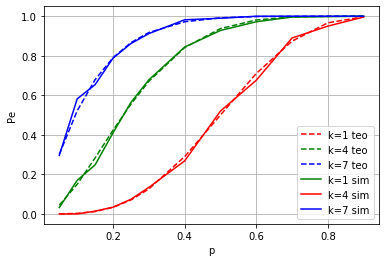

In [13]:
import matplotlib.pyplot as plt

Pe_hamming = [hamErrorProb(p) for p in p_]
Pe_rep = [repErrorProb(p) for p in p_]
Pe_uno = [unoErrorProb(p) for p in p_]

plt.figure()
plt.grid()
plt.plot(p_, Pe_rep, get_color_k(1)+'--')
plt.plot(p_, Pe_hamming, get_color_k(4)+'--')
plt.plot(p_, Pe_uno, get_color_k(7)+'--')

for k in k_:
    datax = []
    datay = []
    for p in res[k]:
        Pe = res[k][p]
        datax.append(p)
        datay.append(Pe)
    plt.plot(datax, datay, get_color_k(k))

plt.xlabel("p")
plt.ylabel("Pe")
plt.legend(["k=1 teo", "k=4 teo", "k=7 teo","k=1 sim", "k=4 sim", "k=7 sim"])
plt.show()